In [2]:
import glob
import os
import numpy as np
np.random.seed(10)

import cv2
import tensorflow as tf

from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
img_width, img_height = 224, 224
train_data_dir = 'podstawy-aproksymacji/processed_data/train'
validation_data_dir = 'podstawy-aproksymacji/processed_data/validation'

In [4]:
def get_n_files(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len(files)
    return count

In [5]:
# read images
n_train_samples = get_n_files(train_data_dir)
n_validation_samples = get_n_files(validation_data_dir)
# training params
epochs = 12
batch_size = 32
input_shape = (img_width, img_height, 3)

In [6]:
# prepare data generators
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.1, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height),
                                                    batch_size=batch_size, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height),
                                                        batch_size=batch_size, class_mode='binary')

Found 381 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [7]:
images = []

n_damaged = 0
n_undamaged = 0

# load images from the validation directory and count the number
# of instances belonging to each of the classes
for directory in ['undamaged', 'damaged']:
    full_img_paths = glob.glob(os.path.join(validation_data_dir, directory, '*'))
    for img_path in full_img_paths:
        try:
            image = io.imread(img_path)
            image = cv2.resize(image, (224, 224))
            images.append(image.reshape(1, 224, 224, 3))
            n_damaged += int('undamaged' not in directory)
            n_undamaged += int('undamaged' in directory)
        except ValueError:
            continue

images = np.vstack(images)
images = images / 255.0

In [8]:
# check which class is represented by 1
class_dict = validation_generator.class_indices
print(class_dict)

{'damaged': 0, 'undamaged': 1}


In [9]:
# create a vector of true classes in the validation set
y_test = n_undamaged * [class_dict['undamaged']] + n_damaged * [class_dict['damaged']]

In [10]:
# random prediction
y_pred_random = np.random.randint(0, 1, len(images))

# model that always predicts most prevalent class
y_pred_mono = len(images) * [max(set(y_test), key=y_test.count)]

# baseline accuracies
print('Accuracy (random model): ', accuracy_score(y_test, y_pred_random))
print('Accuracy (model always predicting the most prevalent class): ', accuracy_score(y_test, y_pred_mono))

Accuracy (random model):  0.4787234042553192
Accuracy (model always predicting the most prevalent class):  0.5212765957446809


In [11]:
# model - jano
model_jano = Sequential()

model_jano.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model_jano.add(MaxPooling2D((2, 2)))

model_jano.add(Conv2D(24, (3, 3), activation='relu'))
model_jano.add(MaxPooling2D((2, 2)))

model_jano.add(Conv2D(32, (3, 3), activation='relu'))
model_jano.add(MaxPooling2D((2, 2)))

model_jano.add(Conv2D(40, (3, 3), activation='relu'))
model_jano.add(MaxPooling2D((2, 2)))

model_jano.add(Conv2D(48, (3, 3), activation='relu'))
model_jano.add(MaxPooling2D((2, 2)))

model_jano.add(Conv2D(64, (3, 3), activation='relu'))
model_jano.add(MaxPooling2D((2, 2)))

model_jano.add(Flatten())
model_jano.add(Dense(64, activation='relu'))
model_jano.add(Dropout(0.2))

model_jano.add(Dense(1, activation='sigmoid'))

In [12]:
optimizer_jano = Adam(learning_rate=0.001)
model_jano.compile(loss='binary_crossentropy',
              optimizer=optimizer_jano,
              metrics=['accuracy'])

In [13]:
history_jano = model_jano.fit_generator(train_generator, steps_per_epoch=n_train_samples // batch_size, epochs=epochs,
                              validation_data=validation_generator, validation_steps=n_validation_samples // batch_size)

<ipython-input-13-f48d33bc8d5b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_jano = model_jano.fit_generator(train_generator, steps_per_epoch=n_train_samples // batch_size, epochs=epochs,


Epoch 1/12
11/11 [==============================] - 33s 3s/step - loss: 0.6940 - accuracy: 0.4957 - val_loss: 0.6913 - val_accuracy: 0.4844
Epoch 2/12
11/11 [==============================] - 23s 2s/step - loss: 0.6890 - accuracy: 0.5501 - val_loss: 0.6800 - val_accuracy: 0.5312
Epoch 3/12
11/11 [==============================] - 23s 2s/step - loss: 0.6582 - accuracy: 0.6074 - val_loss: 0.7598 - val_accuracy: 0.4844
Epoch 4/12
11/11 [==============================] - 21s 2s/step - loss: 0.6340 - accuracy: 0.6361 - val_loss: 0.6781 - val_accuracy: 0.5781
Epoch 5/12
11/11 [==============================] - 21s 2s/step - loss: 0.6085 - accuracy: 0.6819 - val_loss: 0.7383 - val_accuracy: 0.5469
Epoch 6/12
11/11 [==============================] - 21s 2s/step - loss: 0.6166 - accuracy: 0.6533 - val_loss: 0.6452 - val_accuracy: 0.6094
Epoch 7/12
11/11 [==============================] - 21s 2s/step - loss: 0.6026 - accuracy: 0.6447 - val_loss: 0.7754 - val_accuracy: 0.5469
Epoch 8/12
11/11 [==

In [14]:
# make predictions using trained model jano
y_pred_jano = np.where(model_jano.predict(images) > 0.5, 1, 0)

3/3 [==============================] - 1s 310ms/step


In [15]:
# model jano results
print('Model JANO accuracy: ', accuracy_score(y_test, y_pred_jano))
print(confusion_matrix(y_test, y_pred_jano))

Model JANO accuracy:  0.7659574468085106
[[40  5]
 [17 32]]


In [16]:
# model - ania
model_ania = Sequential()

model_ania.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_ania.add(MaxPooling2D((2, 2)))
model_ania.add(Dropout(0.1))

model_ania.add(Conv2D(48, (3, 3), activation='relu', input_shape=input_shape))
model_ania.add(MaxPooling2D((2, 2)))
model_ania.add(Dropout(0.1))

model_ania.add(Conv2D(64, (3, 3), activation='relu'))
model_ania.add(MaxPooling2D((2, 2)))
model_ania.add(Dropout(0.1))

model_ania.add(Flatten())
model_ania.add(Dense(64, activation='relu'))
model_ania.add(Dropout(0.2))

model_ania.add(Dense(1, activation='sigmoid'))

In [17]:
optimizer_ania = Adam(learning_rate=0.001)
model_ania.compile(loss='binary_crossentropy',
              optimizer=optimizer_ania,
              metrics=['accuracy'])

In [18]:
history_ania = model_ania.fit_generator(train_generator, steps_per_epoch=n_train_samples // batch_size, epochs=epochs,
                              validation_data=validation_generator, validation_steps=n_validation_samples // batch_size)

<ipython-input-18-b86a40f6542d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_ania = model_ania.fit_generator(train_generator, steps_per_epoch=n_train_samples // batch_size, epochs=epochs,


Epoch 1/12
11/11 [==============================] - 34s 3s/step - loss: 0.9298 - accuracy: 0.5215 - val_loss: 0.6879 - val_accuracy: 0.5156
Epoch 2/12
11/11 [==============================] - 33s 3s/step - loss: 0.6880 - accuracy: 0.5483 - val_loss: 0.6859 - val_accuracy: 0.5781
Epoch 3/12
11/11 [==============================] - 33s 3s/step - loss: 0.6830 - accuracy: 0.5244 - val_loss: 0.6847 - val_accuracy: 0.7031
Epoch 4/12
11/11 [==============================] - 33s 3s/step - loss: 0.6558 - accuracy: 0.6307 - val_loss: 0.6345 - val_accuracy: 0.7500
Epoch 5/12
11/11 [==============================] - 34s 3s/step - loss: 0.5866 - accuracy: 0.6848 - val_loss: 0.6063 - val_accuracy: 0.6875
Epoch 6/12
11/11 [==============================] - 33s 3s/step - loss: 0.5613 - accuracy: 0.7106 - val_loss: 0.5561 - val_accuracy: 0.7188
Epoch 7/12
11/11 [==============================] - 33s 3s/step - loss: 0.5167 - accuracy: 0.7564 - val_loss: 0.5962 - val_accuracy: 0.6406
Epoch 8/12
11/11 [==

In [19]:
y_pred_ania = np.where(model_ania.predict(images) > 0.5, 1, 0)

3/3 [==============================] - 2s 501ms/step


In [20]:
# model ania results
print('Model ANIA accuracy: ', accuracy_score(y_test, y_pred_ania))
print(confusion_matrix(y_test, y_pred_ania))

Model ANIA accuracy:  0.7021276595744681
[[25 20]
 [ 8 41]]


In [21]:
# model - zuku

model_zuku = Sequential()

model_zuku.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_zuku.add(MaxPooling2D((2, 2)))

model_zuku.add(Conv2D(64, (3, 3), activation='relu'))
model_zuku.add(MaxPooling2D((2, 2)))

model_zuku.add(Flatten())
model_zuku.add(Dense(64, activation='relu'))
model_zuku.add(Dropout(0.2))

model_zuku.add(Dense(1, activation='sigmoid'))

In [22]:
optimizer_zuku = Adam(learning_rate=0.001)
model_zuku.compile(loss='binary_crossentropy',
              optimizer=optimizer_zuku,
              metrics=['accuracy'])

In [23]:
history_zuku = model_zuku.fit_generator(train_generator, steps_per_epoch=n_train_samples // batch_size, epochs=epochs,
                              validation_data=validation_generator, validation_steps=n_validation_samples // batch_size)

<ipython-input-23-4cf183f6234b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_zuku = model_zuku.fit_generator(train_generator, steps_per_epoch=n_train_samples // batch_size, epochs=epochs,


Epoch 1/12
11/11 [==============================] - 31s 3s/step - loss: 2.6240 - accuracy: 0.4928 - val_loss: 0.6903 - val_accuracy: 0.5625
Epoch 2/12
11/11 [==============================] - 30s 3s/step - loss: 0.6718 - accuracy: 0.5845 - val_loss: 0.6304 - val_accuracy: 0.6719
Epoch 3/12
11/11 [==============================] - 30s 3s/step - loss: 0.6134 - accuracy: 0.6791 - val_loss: 0.6151 - val_accuracy: 0.7031
Epoch 4/12
11/11 [==============================] - 30s 3s/step - loss: 0.5636 - accuracy: 0.7163 - val_loss: 0.5670 - val_accuracy: 0.7031
Epoch 5/12
11/11 [==============================] - 30s 3s/step - loss: 0.4877 - accuracy: 0.7822 - val_loss: 0.6453 - val_accuracy: 0.7031
Epoch 6/12
11/11 [==============================] - 30s 3s/step - loss: 0.4247 - accuracy: 0.8109 - val_loss: 0.7514 - val_accuracy: 0.6719
Epoch 7/12
11/11 [==============================] - 31s 3s/step - loss: 0.4588 - accuracy: 0.7880 - val_loss: 0.6196 - val_accuracy: 0.7500
Epoch 8/12
11/11 [==

In [24]:
# make predictions using trained model zuku
y_pred_zuku = np.where(model_zuku.predict(images) > 0.5, 1, 0)

3/3 [==============================] - 2s 499ms/step


In [25]:
# model zuku results
print('Model ZUKU accuracy: ', accuracy_score(y_test, y_pred_zuku))
print(confusion_matrix(y_test, y_pred_zuku))

Model ZUKU accuracy:  0.776595744680851
[[35 10]
 [11 38]]


In [26]:
# create roc curve and auc
from sklearn.metrics import roc_curve, auc

In [27]:
# calculate roc for every model
fpr_jano, tpr_jano, thresholds_jano = roc_curve(y_test, model_jano.predict(images).ravel())
fpr_ania, tpr_ania, thresholds_ania = roc_curve(y_test, model_ania.predict(images).ravel())
fpr_zuku, tpr_zuku, thresholds_zuku = roc_curve(y_test, model_zuku.predict(images).ravel())

3/3 [==============================] - 2s 487ms/step


In [28]:
# calculate auc
auc_jano = auc(fpr_jano, tpr_jano)
auc_ania = auc(fpr_ania, tpr_ania)
auc_zuku = auc(fpr_zuku, tpr_zuku)

In [29]:
import matplotlib.pyplot as plt

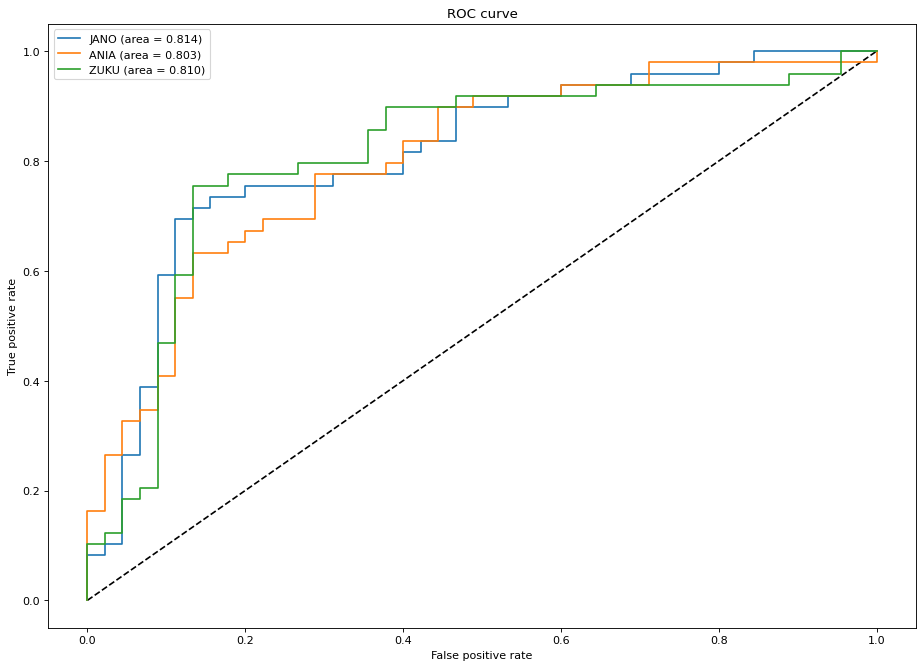

In [30]:
plt.figure(figsize=(14, 10), dpi=80)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_jano, tpr_jano, label='JANO (area = {:.3f})'.format(auc_jano))
plt.plot(fpr_ania, tpr_ania, label='ANIA (area = {:.3f})'.format(auc_ania))
plt.plot(fpr_zuku, tpr_zuku, label='ZUKU (area = {:.3f})'.format(auc_zuku))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()